1.1926944369134491 1.121839406808649 119.18493335282362
1.1410278381077152 0.9271264675807592 102.28229694767715


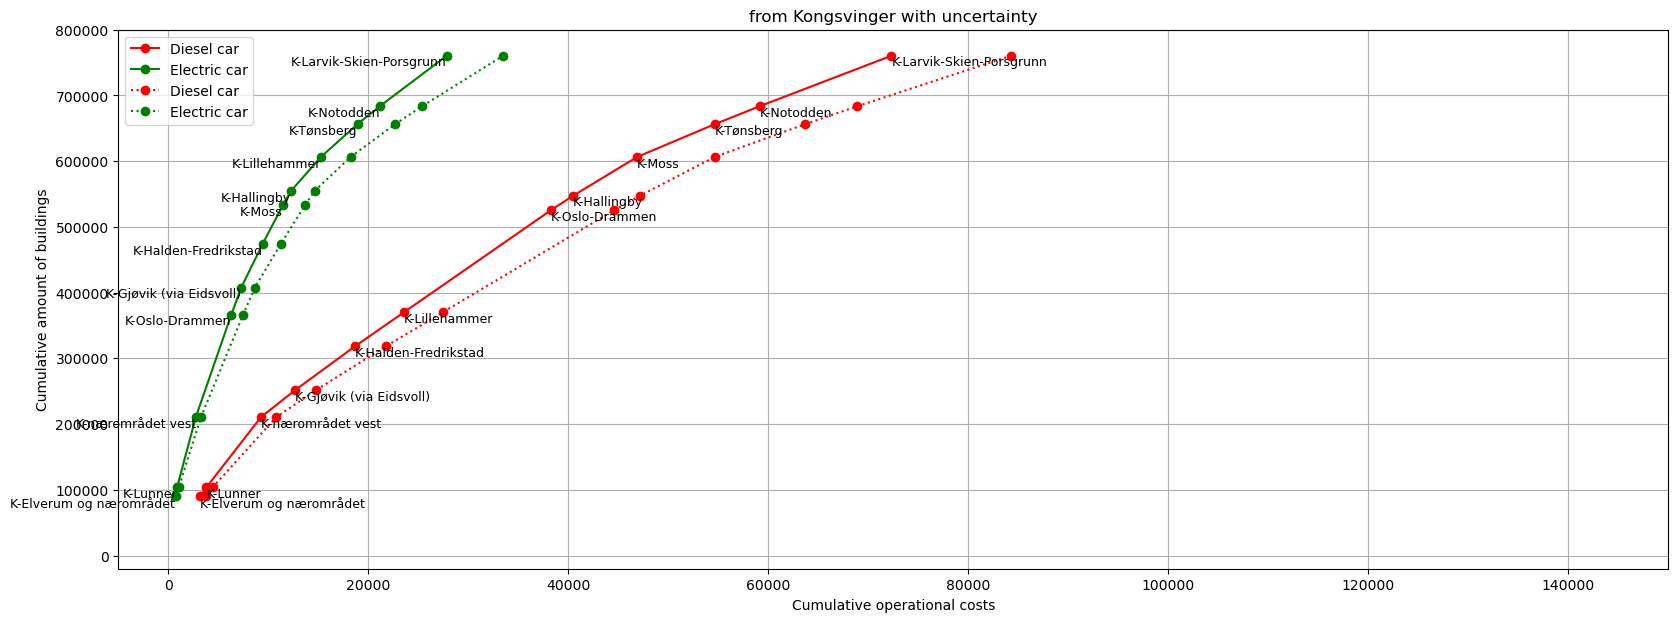

In [622]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class DeliveryWithinArea():
    
    def __init__(self, ab, trips, w, dp, ep, eps, trips_noise, w_noise, ep_noise):
        
        # noise levels: - standard deviation for relative noise
        
        self.ab = ab    # total amount of buildings in area of reach
        self.trips = trips # total trips per year
        self.w = w # winter coefficient, accounts for extra charging costs for electric cars during colder season (considered to last 1/3 of a year)
        self.dp = dp # diesel price, kr/L
        self.ep = ep # grid electricity price, kr/kWh
        self.eps = eps # supercharger electricity price, kr/kWh

        self.trips_noise = trips_noise
        self.w_noise = w_noise
        self.ep_noise = ep_noise

        self.df = pd.read_excel('exercise_1_df.xlsx')
        self.share = self.df["share of buildings in total area of reach"] # % of buildings in total area of reach for particular route
        self.abr = self.share * ab # amount of buildings along route = % of buildings in total area of reach * total amount of buildings in the area of reach
        self.df["amount of buildings along route"] = self.abr # establishing new column in the dataframe
        self.dist1way = self.df["distance one way, km"] # length of the route
        self.dbf = self.df["density balance factor"] # how much density of buildings is biased to the end of route

        self.df_sorted_d = None  #
        self.df_sorted_e = None  #     
        self.df_sorted_e_prev = None  # initializing previous diesel simulation
        self.df_sorted_d_prev = None  # initializing previous electric simulation

    def update_noise(self):    # new noise values for a single simulation run
        rng = np.random.default_rng()
    
        self.trips_n = self.trips * (1 + rng.normal(0, self.trips_noise))
        self.w_n = self.w * (1 + rng.normal(0, self.w_noise))
        self.ep_n = self.ep * (1 + rng.normal(0, self.ep_noise))

        self.typ_trp1way = self.dist1way * self.dbf # typical trip one way, km = distance one way, km * density balance factor
        self.trips_rte = self.trips_n * self.share # amount of trips for the route per year = total amount of trips * % of buildings in total area of reach
        self.dist_driven = self.trips_rte * self.typ_trp1way * 2 # total distance driven in the route per year = amount of trips for the route per year * typical trip one way, km * 2

        print(self.ep_n, self.w_n, self.trips_n)

    def leppard86(self, cons_e = 30, serv_e_10k = 1400):
        self.df_sorted_e_prev = self.df_sorted_e.copy() if self.df_sorted_e is not None else None

        toll_e = self.df["road toll E-car one way, kr"] # road toll one way
        exch_r = self.df["extra charge on route, kWh"] # need for extra charging at superchargers along road, per trip
        toll_cost_e = toll_e * self.trips_rte * 2 # total road toll costs for the route
        drv_cost_e = self.ep_n * cons_e/100 * self.dist_driven # total driving costs = el. price * el.consumption, kWh/100 km * total distance driven in the route
        exch_cost_e = exch_r * self.eps * self.trips_rte * (2 + self.w_n)/3 # total extra charging costs = extra chrg per trip * el. price at superchargers * amount of trips for the route per year * (2 + winter coeff.)/3 
        serv_cost_e = serv_e_10k / 10000 * self.dist_driven # total service costs = service costs per 10000 km / 10000 * distance driven in the route
        op_cost_e = toll_cost_e + drv_cost_e + exch_cost_e + serv_cost_e # total operational cost

        self.df["rank_e"] = self.abr / op_cost_e # new column with ranking by "amount of buldings along route/ operational costs along route" ratio
        self.df_sorted_e = self.df.sort_values(by="rank_e", ascending=False) # sorting the dataframe and making a new one of it
        self.df_sorted_e["Total operational costs on route"] = op_cost_e
        self.df_sorted_e["Cumulative amount of buildings"] = self.df_sorted_e["amount of buildings along route"].cumsum()
        self.df_sorted_e["Cumulative operational costs"] = self.df_sorted_e["Total operational costs on route"].cumsum()
        
    def leppard87(self, cons_d = 10, serv_d_10k = 3000):
        self.df_sorted_d_prev = self.df_sorted_d.copy() if self.df_sorted_d is not None else None

        toll_d = self.df["road toll D-car one way, kr"] # road toll one way
        toll_cost_d = toll_d * self.trips_rte * 2 # total road toll costs for the route
        drv_cost_d = self.dp * cons_d/100 * self.dist_driven # total driving costs = diesel price * diesel consumption, L/100 km * distance driven in the route
        serv_cost_d = serv_d_10k / 10000 * self.dist_driven  # total service costs = service costs per 10000 km / 10000 * distance driven in the route
        op_cost_d = toll_cost_d + drv_cost_d + serv_cost_d # total operational cost

        self.df["rank_d"] = self.abr / op_cost_d # new column with ranking by "amount of buldings along route/ operational costs along route" ratio
        self.df_sorted_d = self.df.sort_values(by="rank_d", ascending=False) # sorting the dataframe by rank and making a new one of it
        self.df_sorted_d["Total operational costs on route"] = op_cost_d
        self.df_sorted_d["Cumulative amount of buildings"] = self.df_sorted_d["amount of buildings along route"].cumsum()
        self.df_sorted_d["Cumulative operational costs"] = self.df_sorted_d["Total operational costs on route"].cumsum()
    
    def bangforbucks_with_noise(self):
        self.x_d = self.df_sorted_d["Cumulative operational costs"]
        self.x_e = self.df_sorted_e["Cumulative operational costs"]
        self.y_d = self.df_sorted_d["Cumulative amount of buildings"]
        self.y_e = self.df_sorted_e["Cumulative amount of buildings"]

        self.x_d_prev = self.df_sorted_d_prev["Cumulative operational costs"] if self.df_sorted_d_prev is not None else None
        self.y_d_prev = self.df_sorted_d_prev["Cumulative amount of buildings"] if self.df_sorted_d_prev is not None else None
        self.x_e_prev = self.df_sorted_e_prev["Cumulative operational costs"] if self.df_sorted_e_prev is not None else None
        self.y_e_prev = self.df_sorted_e_prev["Cumulative amount of buildings"] if self.df_sorted_e_prev is not None else None

    def plot_bangforbucks_with_noise(self):
        plt.figure(figsize=(20, 7))
        plt.plot(self.x_d, self.y_d, label = "Diesel car", linestyle='-', color='r', marker='o')
        plt.plot(self.x_e, self.y_e, label = "Electric car", linestyle='-', color='g', marker='o')
        if self.df_sorted_d_prev is not None:
            plt.plot(self.x_d_prev, self.y_d_prev, label = "Diesel car", linestyle=':', color='r', marker='o')
        if self.df_sorted_e_prev is not None:
            plt.plot(self.x_e_prev, self.y_e_prev, label = "Electric car", linestyle=':', color='g', marker='o')
        for _, row in self.df_sorted_e.iterrows():
            plt.text(row["Cumulative operational costs"], row["Cumulative amount of buildings"], str(row['route']), fontsize=9, ha='right', va='top', color='k')
        for _, row in self.df_sorted_d.iterrows():
            plt.text(row["Cumulative operational costs"], row["Cumulative amount of buildings"], str(row['route']), fontsize=9, ha='left', va='top', color='k')
        #for _, row in self.df_sorted_e_prev.iterrows():
            #plt.text(row["Cumulative operational costs"], row["Cumulative amount of buildings"], str(row['route']), fontsize=9, ha='left', va='bottom', color='g')
        #for _, row in self.df_sorted_d_prev.iterrows():
            #plt.text(row["Cumulative operational costs"], row["Cumulative amount of buildings"], str(row['route']), fontsize=9, ha='left', va='bottom', color='r')
        plt.title('from Kongsvinger with uncertainty')
        plt.xlim(-5000, 150000)
        plt.ylim(-20000, 800000)
        plt.xlabel('Cumulative operational costs')
        plt.ylabel('Cumulative amount of buildings')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

plot = DeliveryWithinArea(ab=760500, trips=120, w=1.5, dp=21, ep=0.9, eps=5.5, trips_noise=0.15, w_noise=0.2, ep_noise = 0.4)

plot.update_noise() 
plot.leppard87()
plot.leppard86()

plot.update_noise() 
plot.leppard87()
plot.leppard86()

plot.bangforbucks_with_noise()
plot.plot_bangforbucks_with_noise()